In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime

from tda.client import Client
from tda.auth import easy_client
import stream.login.config as config


#create the client to talk to td ameritrade
#initialize a session
client = easy_client(
    config.API_KEY,
    config.REDIRECT_URI,
    config.TOKEN_PATH
)


In [2]:
def wol( trig_time, profit_ratio, loss_ratio, df, i):  # win or loss?  Ps the trig_price is the open price of the next minute
    # find time to start searching original df
    i = i+1
    j = i+1
    trig_price = df.iloc[i, 0]
    df = df.iloc[j:,:] 

    # compare prices
    for i,row in df.iterrows():
        # row[2] corresponds to low min price
        if row[2] >= trig_price * profit_ratio:
            return 'profit'     # indicates a sell/profit
        # row[1] corresponds to high min price
#         elif row[1] <= trig_price * loss_ratio:
#             return 'loss'     # indicates a sell/loss
        else:
            continue

#With the WOL function - create a comprehension that will then be used as a column to indicate win or loss

def wol_time( trig_time, profit_ratio, loss_ratio, df, i):  # win or loss?  Ps the trig_price is the open price of the next minute
    # find time to start searching original df
    i = i+1
    j = i+1
    trig_price = df.iloc[i, 0]
    df = df.iloc[j:,:] 

    # compare prices
    for i,row in df.iterrows():
        # compare to low of min row[2]
        if row[2] >= trig_price * profit_ratio:
            return (row[5] - trig_time)/60000     # indicates a sell/profit
        # compare to high of min row[1]
#         elif row[1] <= trig_price * loss_ratio:
#             return (row[5] - trig_time)/60000      # indicates a sell/loss
        else:
            continue

In [3]:
n = 14


def rma(x, n, y0):
    a = (n-1) / n
    ak = a**np.arange(len(x)-1, -1, -1)
    return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]


In [4]:
symbols = ['BLDP', 'ENG', 'NCLH', 'MRO', 'NNDM', 'CCL', 'FCX', 'ET', 'MARA',
       'RIOT', 'COTY', 'FTFT', 'TSLA', 'SQ', 'MGM', 'SPWR', 'SLB', 'WPRT', 'BLNK', 'FTI', 'SM', 'SUNW',
       'DDD', 'DVN', 'VUZI']
symbols = symbols[:4]
symbols = ["MGM","MARA","SLB","BLDP","SM"]
symbols = ['BLDP', 'ENG', 'NCLH', 'MRO', 'NNDM', 'CCL', 'FCX', 'ET', 'MARA',
       'RIOT', 'COTY', 'FTFT', 'TSLA', 'SQ', 'MGM', 'SPWR', 'SLB', 'WPRT', 'BLNK', 'FTI', 'SM', 'SUNW',
       'DDD', 'DVN', 'VUZI']
symbols = ["FTFT", "SUNW", "ENG", "MARA", "RESN", "SOL", "CRNT", "UAVS", "CRIS", "RRC", "RIOT", "GEVO", "BBBY", "CLXT", "FCEL", "TTM", "SRNE", "SM", "ARCT", "AR", "W", "BLDP", "CRSP", "CBAT", "OXY", "WPRT", "PEIX", "MAC", "GRWG", "SKT", "MIK", "FTI", "NVTA", "PAA", "SPWR", "X", "AMRN", "OSTK", "MGY", "DVN", "MRO", "MVIS", "SOLO", "CYH", "APA", "RUN", "MUR", "BIG", "OVV", "DPW", "VET", "EOG", "BCRX", "WKHS", "CPE", "TSLA", "FCX", "JWN", "M", "OKE", "PENN", "FUBO", "KNDI", "SLB", "NNDM", "ET", "CLF", "PBF", "PLAY", "PRTY", "BLNK", "CNK", "HAL", "AYRO", "EDIT", "CZR", "NOV", "CLSK", "KSS", "MPC", "IGT", "GT"]
symbols = ["BCS", "SEE", "VFC", "IRWD", "PBR.A", "CNQ", "ING", "PBR", "LVS", "CVE", "OUT", "KAR", "SID", "PRTS", "NOV", "XRX", "AA", "MLCO", "EDIT", "ENDP", "BTG", "AUY", "AGI", "PAAS", "EGO", "FSM", "CDE", "GBTC", "CLSK", "HL", "CRDF", "SRPT"]

#high pe
symbols = ['ENG', 'GROW', 'FLNT']
#low pe
symbols = ["LEU", "EBIX", "SIVB", "SKYW", "AYRO", "BGFV", "TSC", "MIK", "NBLX", "IMTE", "ADS", "MTOR", "BIG", "BXC", "BZH", "GPI", "GTN", "GTN.A", "HNGR", "HOV", "LNC", "MHO", "TTM", "URI", "MGM", "ACCO", "KOP", "LL", "FOR", "VRS", "TROX", "AL", "CAPL", "DKL", "WES", "BCC", "OMF", "HESM", "NGVT", "ATKR", "CWH"]
# symbols = ["SIVB", "GS", "URI", "AMP", "WHR", "SNA", "HCA", "ABG", "JLL", "MHK", "GPI", "PRI", "WRLD", "WSM", "AYI", "CE", "IBM", "NXST", "DVA", "CRMT", "EXP", "EVR", "LPLA", "LGIH", "CW", "BBY", "RJF", "ARW"]
symbols = ["LNG", "LEU", "ABCB", "AMKR", "BBSI", "BOTJ", "BPOP", "BSRR", "CATY", "PRDO", "CHY", "CRAI", "CRMT", "DISH", 
           "DMLP", "EBIX", "ECPG", "EDUC", "ESCA", "EWBC", "FFBC", "FISI", "FITB", "FRME", "FSTR", "HAFC", "HBNC", 
           "HIBB", "HOLX", "HTLF", "SNEX", "IBOC", "IIIN", "KFRC", "LKQ", "HOPE", "NBN", "NCTY", "NEWT", "NSIT", 
           "NXST", "OSBC", "OZK", "PFBC", "PFG", "PLUS", "PLXS", "PNFP", "PRAA", "SBFG", "RCII", "SLM", "STLD", 
           "STRL", "TBBK", "TSBK", "AUB", "UBSI", "UCBI", "UFPI", "UNTY", "VLY", "WLFC", "WRLD", "WTFC", "WW", "ULH", 
           "BGFV", "ZUMZ", "EFSC", "VIAC", "QRTEA", "HOMB", "COWN", "PRIM", "CSIQ", "TA", "SMCI", "GRBK", "OPI", 
           "PBCT", "IRWD", "HEAR", "SUNS", "AMCX", "FDUS", "COOP", "SUPN", "FSBW", "WHF", "TSC", "OTEL", "LGIH", 
           "NMIH", "NAVI", "MIK", "VBTX", "CHRS", "FFWM", "MOMO","UNM", "VHI", "WHR", "WRI", "WSM", "SPB", "AX", 
           "MGM", "TGP", "HTGC", "WAL", "AMP", "GLP", "FNF", "BMA", "TRTN", "KOP", "EVR", "HBI", "CS", "DAC", "SBH", 
           "SAR", "CZZ", "FLY", "TGH", "LL", "FOR", "VRS", "GSL", "EC", "CLW", "STWD", "SEM", "CAI", "PRI", "TROX", 
           "BKU", "HCA", "AL", "BCEI", "CUBI", "ALSN", "RM", "NGVC", "BERY", "CAPL", "DKL", "WES", "VTOL", "TPH", 
           "BCC", "SBSW", "TMHC", "KNOP", "EARN", "OMF", "ESNT", "ALLY", "TPVG", "TSLX", "TNET", "PBFX", "LPG", "CCS",
           "SYF", "HMLP", "CFG", "BSIG", "SHLX", "ENVA", "HESM", "SUM", "KEN", "AJX", "ACV", "NGVT", "ATKR", "VVV", 
           "NTB", "CWH", "ATH", "BY", "BPMP","XBIT", "CCD", "NBLX", "LSXMA", "FHB", "ABG", "AB", "ADS", "AEL", "AN", 
           "MTOR", "ARW", "IVZ", "AYI", "BAC", "TFC", "BBY", "BC", "BEN", "BIG", "BLX", "BXC", "BXP", "BXS", "BZH",
           "C", "CE", "CFR", "CMA", "CMC", "CNO", "CPF", "CTB", "CYD", "DHI", "DKS", "DRD", "ATGE", "DVA", "DX", "EPD",
           "EXP", "FBC", "FHN", "FL", "FNB", "GBL", "TGNA", "GFF", "GPI", "GS", "GTN", "GTN.A", "HOV", "HVT", "HVT.A",
           "HZO", "IBM", "INT", "JLL", "KBH", "KEY", "KIM", "KNX", "LAD", "LEN", "LEN.B", "JEF", "MDC", "MET", "MEI",
           "MHO", "MTG", "MTH", "MS", "MYE", "NCR", "OI", "OLP", "STL", "PHM", "PB", "RDN", "RF", "RGA", "RJF", "SCS",
           "SEE", "SF", "SLG", "SNA", "SNV", "SNX", "STT", "TKR", "TOL", "TTM", "PAG", "UHS", "UNFI"]
            

In [6]:
days = 10
sym_dict = []
real_roi = list()
daily_roi = list()


# loop through chosen symbols
# symbols chosen by high volume and high beta
for i,symbol in enumerate(symbols):
    
    # Get the price history iteratively
    data = client.get_price_history(
        symbol, 
        period_type=Client.PriceHistory.PeriodType.DAY,
        period=Client.PriceHistory.Period.TEN_DAYS,
        frequency_type=Client.PriceHistory.FrequencyType.MINUTE,
        frequency=Client.PriceHistory.Frequency.EVERY_MINUTE)
    data = data.json()

    
    # Create dataframe with new features
    test = pd.DataFrame(data['candles'])
    test['time'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%I:%M:%S"),axis=1 )
    test['day'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%d"),axis=1 )
    test['month'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%B"),axis=1 )
    #     test['year'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%Y"),axis=1 )
    #create open to high column
    test['open_high'] = test['high']-test['open']
    #create open to low column
    test['open_low'] = test['open']-test['low']
    
    
    ## CREATE RSI INDICATOR
    test['change'] = test['close'].diff()
    test['gain'] = test.change.mask(test.change < 0, 0.0)
    test['loss'] = -test.change.mask(test.change > 0, -0.0)
    test['avg_gain'] = rma(test.gain[n+1:].to_numpy(), n, np.nansum(test.gain.to_numpy()[:n+1])/n)
    test['avg_loss'] = rma(test.loss[n+1:].to_numpy(), n, np.nansum(test.loss.to_numpy()[:n+1])/n)
    test['rs'] = test.avg_gain / test.avg_loss
    test['rsi_14'] = 100 - (100 / (1 + test.rs))

    
    
    # Define the conditions for the trigger
    #define variables
    candle_diff = 1.2
    morn15 = ['08:{}:00'.format(30+x) for x in range(0,15)]
    second = ['08:{}:00'.format(30+x) for x in range(15,31)]

    # --------------------------------------------------condition for trigger-----------------------------------
    #define open higher than open low
    high_not_zero = test['open_high'] != 0 
    low_not_zero = test['open_low'] != 0 
    tall_candle = test['open_high'] > candle_diff*test['open_low']
    volume75 = test['volume'] >= np.percentile(test['volume'],[0])[0] #90
    rsi = (test['rsi_14']<70) & (test['rsi_14']>30)
    less_max = test['open'] *1.01 < test.high.max()
    high_min = test['open'] *0.99 > test.low.min()
    high_day = test['open'] *1.003 < test.iloc[:480,:].max()[0]
    low_day = test['open'] * 0.997 > test.iloc[:480,:].min()[0]
#     price65th = test['open']<np.percentile(test['high'],[95])[0] #65
#     rsi_ind = test['rsi_14'] > test['rsi_14_d']
    #     volume75 = test['volume'] <= np.percentile(test['volume'],[10])[0] #90
#     not_first15 = ~test['time'].isin(morn15)
    second15 = test['time'].isin(second)
    #     down_trend = past_high_mean < recent_low_mean * 1.02
    #     price35th = test['open']>np.percentile(test['high'],[45])[0]
    #     time_test = (test['time']>'08:30:00')&(test['time']<'09:00:00')

#     condition = high_not_zero & low_not_zero & tall_candle & volume75 & rsi& less_max& high_min& high_day& low_day &first15# & price65th & not_first15# & time_test & price35th & down_trend
    condition = (test['rsi_14']<30) & second15
    print(second)
    
    print('day_low: ',test.iloc[:480,:].min()[0])
    
    # Checking for trigger, store in trigger_df
    trigger_df = test.loc[condition, :].reset_index()

    
    
    
    #add column of desired sell prices and loss prices
    #desired roi is 0.2%
    
    
    #    _____________________________________________-    ROI    -________________________________________________
    
    roi = 0.0075
    
    
    my_profit = 1+roi  #1.004
#     my_profit = 1+roi
    trigger_df['to_sell_price'] = trigger_df.close * my_profit
    
    my_loss = 1-(roi*.4) #0.9986
#     my_loss = (1-.01)
    trigger_df['to_loss_price'] = trigger_df.close * my_loss
    
    trigger_df['wol'] = [ wol( row[6], my_profit, my_loss, test, row[0]) for i,row in trigger_df.iterrows() ]
    
    trigger_df['wol_time'] = [ wol_time( row[6], my_profit, my_loss, test, row[0]) for i,row in trigger_df.iterrows() ]
    
    
    
    print(symbol,i)
    print(trigger_df.wol.value_counts())
    
    
    profit = trigger_df.loc[trigger_df['wol']=='profit','wol'].count()
    loss = trigger_df.loc[trigger_df['wol']=='loss','wol'].count()
    
    print('p ',profit)
    print('l ',loss)

    ind_roi = round((profit*(my_profit-1))-(loss*(1-my_loss)),5)

    ind_time = trigger_df.wol_time.mean()
    print('Average trade time in minutes: ',ind_time)

    what_day = '28'
    
    profit_day = trigger_df.loc[(trigger_df['wol']=='profit')&(trigger_df['day']==what_day),'wol'].count()
    loss_day = trigger_df.loc[(trigger_df['wol']=='loss')&(trigger_df['day']==what_day),'wol'].count()
    
    ind_roi_day = round((profit_day*(my_profit-1))-(loss_day*(1-my_loss)),5)
    print(ind_roi_day)

    sym_data = {
        'symbol':symbol,
        'total_sells':profit,
        'total_loss':loss,
        'min_to_sell':round(ind_time,4),
        'roi_day': ind_roi_day
    }

    # append data to appropriate lists
    sym_dict.append(sym_data)

    real_roi.append((symbol, ind_roi, ind_time))
    daily_roi.append((symbol, ind_roi_day, ind_time)) #, trigger_df.iloc[0,4]
    
    
#     plt.figure(figsize=(30,8))
#     sns.countplot('day', hue='wol', data=trigger_df)
#     plt.title(symbol)
#     plt.show()  
    
    
trades = pd.DataFrame.from_dict(sym_dict, orient='columns')
tradables = list()
tickers = list()
price = list()

# print(real_roi)
for x in real_roi:
    if x[2] < 10:
        tradables.append(x[1])
        tickers.append(x[0])

        

for x in daily_roi:
    if x[2] < 10:
        tradables_day.append(x[1])
        tickers_day.append(x[0])

        


print( sum(tradables) )
print(tradables)
print(tickers)

print('\n daily:')
print( sum(tradables_day) )
print(tradables_day)
print(tickers_day)


['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  62.13
LNG 0
profit    13
Name: wol, dtype: int64
p  13
l  0
Average trade time in minutes:  2668.6923076923076
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  19.78
LEU 1
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  42.64
ABCB 2
profit    2
Name: wol, dtype: int64
p  2
l  0
Average trade time in minutes:  10.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:5

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  52.61
HIBB 27
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  74.51
HOLX 28
profit    5
Name: wol, dtype: int64
p  5
l  0
Average trade time in minutes:  15.2
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  42.31
HTLF 29
profit    10
Name: wol, dtype: int64
p  10
l  0
Average trade time in minutes:  1180.4
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', 

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  16.7
TBBK 54
profit    2
Name: wol, dtype: int64
p  2
l  0
Average trade time in minutes:  3.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  25.2
TSBK 55
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  32.89
AUB 56
profit    2
Name: wol, dtype: int64
p  2
l  0
Average trade time in minutes:  9.5
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  10.2
IRWD 81
profit    2
Name: wol, dtype: int64
p  2
l  0
Average trade time in minutes:  4.5
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  24.61
HEAR 82
profit    1
Name: wol, dtype: int64
p  1
l  0
Average trade time in minutes:  7.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  14.015
SUNS 83
profit    1
Name: wol, dtype: int64
p  1
l  0
Average trade time in minutes:  2878.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  12.12
TGP 108
profit    2
Name: wol, dtype: int64
p  2
l  0
Average trade time in minutes:  1511.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  15.08
HTGC 109
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  68.25
WAL 110
profit    4
Name: wol, dtype: int64
p  4
l  0
Average trade time in minutes:  15.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  130.7
PRI 135
profit    7
Name: wol, dtype: int64
p  7
l  0
Average trade time in minutes:  248.42857142857142
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  16.14
TROX 136
profit    1
Name: wol, dtype: int64
p  1
l  0
Average trade time in minutes:  12.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  36.03
BKU 137
profit    4
Name: wol, dtype: int64
p  4
l  0
Average trade time in minutes:  5.75
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', 

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  9.65
PBFX 162
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  11.41
LPG 163
profit    6
Name: wol, dtype: int64
p  6
l  0
Average trade time in minutes:  158.66666666666666
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  49.29
CCS 164
profit    1
Name: wol, dtype: int64
p  1
l  0
Average trade time in minutes:  5.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  139.82
ABG 189
profit    6
Name: wol, dtype: int64
p  6
l  0
Average trade time in minutes:  6.166666666666667
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  36.0426
AB 190
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  67.6967
ADS 191
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', 

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  36.8724
CTB 216
profit    8
Name: wol, dtype: int64
p  8
l  0
Average trade time in minutes:  2046.5
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  15.81
CYD 217
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  77.7
DHI 218
Series([], Name: wol, dtype: int64)
p  0
l  0
Average trade time in minutes:  nan
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '0

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  154.23
JLL 243
profit    1
Name: wol, dtype: int64
p  1
l  0
Average trade time in minutes:  5912.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  42.0501
KBH 244
profit    2
Name: wol, dtype: int64
p  2
l  0
Average trade time in minutes:  101.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  17.48
KEY 245
profit    4
Name: wol, dtype: int64
p  4
l  0
Average trade time in minutes:  3255.25
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51

['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  13.3
SCS 270
profit    2
Name: wol, dtype: int64
p  2
l  0
Average trade time in minutes:  262.5
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  44.25
SEE 271
profit    4
Name: wol, dtype: int64
p  4
l  0
Average trade time in minutes:  12092.75
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', '08:52:00', '08:53:00', '08:54:00', '08:55:00', '08:56:00', '08:57:00', '08:58:00', '08:59:00', '08:60:00']
day_low:  51.06
SF 272
profit    1
Name: wol, dtype: int64
p  1
l  0
Average trade time in minutes:  11.0
0.0
['08:45:00', '08:46:00', '08:47:00', '08:48:00', '08:49:00', '08:50:00', '08:51:00', 

NameError: name 'tradables_day' is not defined

In [7]:



trades = pd.DataFrame.from_dict(sym_dict, orient='columns')
tradables = list()
tickers = list()
price = list()

# print(real_roi)
for x in real_roi:
    if x[2] < 122:
        tradables.append(x[1])
        tickers.append(x[0])
#         price.append(x[3])

print( sum(tradables) )
print(tradables)
print(tickers)

5.497499999999998
[0.015, 0.0075, 0.0675, 0.015, 0.0225, 0.0525, 0.0675, 0.0225, 0.0975, 0.0225, 0.0075, 0.0075, 0.0075, 0.045, 0.0525, 0.0225, 0.0375, 0.015, 0.0075, 0.0075, 0.03, 0.0825, 0.0075, 0.03, 0.0375, 0.105, 0.0375, 0.0075, 0.015, 0.015, 0.045, 0.06, 0.045, 0.0075, 0.0225, 0.015, 0.09, 0.015, 0.0825, 0.0525, 0.03, 0.06, 0.015, 0.0225, 0.0675, 0.015, 0.0075, 0.03, 0.0075, 0.06, 0.03, 0.0375, 0.015, 0.015, 0.0075, 0.0075, 0.06, 0.0075, 0.0525, 0.03, 0.03, 0.0225, 0.015, 0.0975, 0.0675, 0.0525, 0.0675, 0.0825, 0.075, 0.03, 0.0525, 0.0525, 0.015, 0.0675, 0.0225, 0.0075, 0.03, 0.0525, 0.0225, 0.0225, 0.09, 0.0075, 0.0075, 0.0225, 0.09, 0.0225, 0.0225, 0.0075, 0.0075, 0.015, 0.045, 0.09, 0.045, 0.0075, 0.0225, 0.0225, 0.0075, 0.045, 0.015, 0.0525, 0.045, 0.0075, 0.0225, 0.12, 0.0675, 0.15, 0.0075, 0.03, 0.1725, 0.0075, 0.015, 0.0375, 0.0225, 0.0825, 0.0075, 0.0375, 0.0225, 0.0075, 0.105, 0.0375, 0.045, 0.0525, 0.0825, 0.075, 0.015, 0.03, 0.0525, 0.0225, 0.045, 0.015, 0.045, 0.0375,

In [126]:
trades.loc[trades['min_to_sell']<120,:].sum()

symbol         ABCBBPOPBSRRCATYPRDOCHYCRMTDISHEBIXECPGESCAFFB...
total_sells                                                  827
total_loss                                                     0
min_to_sell                                              4185.93
roi_day                                                    0.225
dtype: object

In [115]:
moola = 25000
print('triggers per hr:',trades.total_sells.sum()/(10*8))
print('avg time to sell per hour: ', round(trades.min_to_sell.mean()/60))
print('units needed: ', trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))
print('percent made per 10 days: ', sum(tradables))
print('money made per 10 days with 10K: ', (moola/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) ) 
print('roi: ', round((10000/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) / moola ,3))

triggers per hr: 40.3125
avg time to sell per hour:  13
units needed:  524.0625
percent made per 10 days:  6.859999999999996
money made per 10 days with 10K:  327.2510435301131
roi:  0.005


In [110]:
moola = 25000
print('triggers per hr:',trades.total_sells.sum()/(10*8))
print('avg time to sell per hour: ', round(trades.min_to_sell.mean()/60))
print('units needed: ', trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))
print('percent made per 10 days: ', sum(tradables))
print('money made per 10 days with 10K: ', (moola/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) ) 
print('roi: ', round((10000/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) / moola ,3))

triggers per hr: 10.325
avg time to sell per hour:  13
units needed:  134.225
percent made per 10 days:  2.03
money made per 10 days with 10K:  378.09647979139504
roi:  0.006


In [106]:
moola = 25000
print('triggers per hr:',trades.total_sells.sum()/(10*8))
print('avg time to sell per hour: ', round(trades.min_to_sell.mean()/60))
print('units needed: ', trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))
print('percent made per 10 days: ', sum(tradables))
print('money made per 10 days with 10K: ', (moola/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) ) 
print('roi: ', round((10000/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) / moola ,3))

triggers per hr: 2.3375
avg time to sell per hour:  21
units needed:  49.0875
percent made per 10 days:  0.4760000000000001
money made per 10 days with 10K:  242.4242424242425
roi:  0.004


In [88]:
moola = 25000
print('triggers per hr:',trades.total_sells.sum()/(10*8))
print('avg time to sell per hour: ', round(trades.min_to_sell.mean()/60))
print('units needed: ', trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))
print('percent made per 10 days: ', sum(tradables))
print('money made per 10 days with 10K: ', (moola/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) ) 
print('roi: ', round((10000/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) / moola ,3))

triggers per hr: 81.9625
avg time to sell per hour:  18
units needed:  1475.325
percent made per 10 days:  31.08499999999999
money made per 10 days with 10K:  526.7483435853115
roi:  0.008


In [91]:
moola = 25000
print('triggers per hr:',trades.total_sells.sum()/(10*8))
print('avg time to sell per hour: ', round(trades.min_to_sell.mean()/60))
print('units needed: ', trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))
print('percent made per 10 days: ', sum(tradables))
print('money made per 10 days with 10K: ', (moola/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) ) 
print('roi: ', round((10000/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) / moola ,3))

triggers per hr: 80.1125
avg time to sell per hour:  18
units needed:  1442.0249999999999
percent made per 10 days:  30.505
money made per 10 days with 10K:  528.8569893032368
roi:  0.008


In [96]:
moola = 25000
print('triggers per hr:',trades.total_sells.sum()/(10*8))
print('avg time to sell per hour: ', round(trades.min_to_sell.mean()/60))
print('units needed: ', trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))
print('percent made per 10 days: ', sum(tradables))
print('money made per 10 days with 10K: ', (moola/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) ) 
print('roi: ', round((10000/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) / moola ,3))

triggers per hr: 84.3375
avg time to sell per hour:  11
units needed:  927.7125000000001
percent made per 10 days:  13.295999999999996
money made per 10 days with 10K:  358.3006588786934
roi:  0.006


In [99]:
moola = 25000
print('triggers per hr:',trades.total_sells.sum()/(10*8))
print('avg time to sell per hour: ', round(trades.min_to_sell.mean()/60))
print('units needed: ', trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))
print('percent made per 10 days: ', sum(tradables))
print('money made per 10 days with 10K: ', (moola/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) ) 
print('roi: ', round((10000/ (trades.total_sells.sum()/(10*8) * round(trades.min_to_sell.mean()/60))) * sum(tradables) / moola ,3))

triggers per hr: 77.6125
avg time to sell per hour:  22
units needed:  1707.475
percent made per 10 days:  40.83100000000001
money made per 10 days with 10K:  597.8272009839092
roi:  0.01


In [24]:
tradables_day = list()
tickers_day = list()
price_day = list()


for x in daily_roi:
    if x[2] < 6000:
        tradables_day.append(x[1])
        tickers_day.append(x[0])
        price_day.append(x[3])
        

print('\n daily:')
print( sum(tradables_day) )
print(tradables_day)
print(tickers_day)


IndexError: tuple index out of range

In [ ]:
trades.roi_day.sum()

In [10]:
trigger_df.loc[(trigger_df['time']>'01:40:00')&(trigger_df['time']<'02:46:00')&(trigger_df['day']=='15'),:]

,index,open,high,low,close,volume,datetime,time,day,month,open_high,open_low,to_sell_price,to_loss_price,wol,wol_time
748,4495,24.9619,24.9932,24.9600,24.9781,22604,1610739660000,01:41:00,15,January,0.0313,0.0019,25.227881,24.853210,None,NaN
749,4496,24.9748,25.0000,24.9700,25.0000,14320,1610739720000,01:42:00,15,January,0.0252,0.0048,25.250000,24.875000,loss,57.0
750,4497,25.0050,25.0200,25.0010,25.0150,6696,1610739780000,01:43:00,15,January,0.0150,0.0040,25.265150,24.889925,loss,56.0
751,4498,25.0150,25.0300,25.0149,25.0169,13102,1610739840000,01:44:00,15,January,0.0150,0.0001,25.267069,24.891815,loss,55.0
752,4501,25.0350,25.0500,25.0250,25.0414,12529,1610740020000,01:47:00,15,January,0.0150,0.0100,25.291814,24.916193,loss,47.0
753,4502,25.0500,25.0700,25.0450,25.0574,12153,1610740080000,01:48:00,15,January,0.0200,0.0050,25.307974,24.932113,loss,46.0
754,4503,25.0550,25.0700,25.0500,25.0700,7342,1610740140000,01:49:00,15,January,0.0150,0.0050,25.320700,24.944650,loss,44.0
755,4510,25.0299,25.0450,25.0250,25.0350,9869,1610740560000,01:56:00,15,January,0.0151,0.0049,25.285350,24.909825,loss,41.0
756,4512,25.0300,25.0500,25.0250,25.0350,10411,1610740680000,01:58:00,15,January,0.0200,0.0050,25.285350,24.909825,loss,39.0
757,4514,25.0400,25.0550,25.0300,25.0350,6741,1610740800000,02:00:00,15,January,0.0150,0.0100,25.285350,24.909825,loss,34.0


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'FOLD')

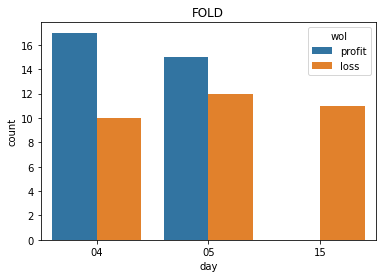

In [44]:
sns.countplot('day', hue='wol', data=trigger_df)
plt.title(symbol)

In [10]:
tradables = list()
tickers = list()
price = list()
for x in real_roi:
    if x[2] < 60 and x[3] > 2:
        tradables.append(x[1])
        tickers.append(x[0])
        price.append(x[3])

print( sum(tradables) )
print(tickers)


51.85071999999999
['FCEL', 'SRNE', 'MARA', 'RIOT', 'FUBO', 'M', 'MVIS', 'X', 'GEVO', 'SOLO', 'LXRX', 'BBBY', 'DVN', 'SPWR', 'RRC', 'SUNW', 'BLNK', 'UAVS', 'BLDP', 'WKHS', 'DPW', 'MIK', 'SABR', 'AR', 'RUN', 'CBAT', 'PBF', 'KNDI', 'BCRX', 'SM', 'CLSK', 'EDIT', 'NVTA', 'CRSP', 'PRTY', 'GRWG', 'CRIS', 'MGNI', 'VUZI', 'OSTK', 'APPS', 'SOL']


In [9]:
perc_prof = trades.loc[trades['min_to_sell']<60, :].sort_values(by='min_to_sell').total_sells.sum() * (my_profit-1)
perc_los = trades.loc[trades['min_to_sell']<60, :].sort_values(by='min_to_sell').total_loss.sum() * (1-my_loss)
perc_prof - perc_los
trades.loc[trades['min_to_sell']<600, :].sort_values(by='min_to_sell').symbol.values

array(['ENG', 'NCLH', 'BLDP', 'MRO'], dtype=object)